# Tutorial 3 - Hidden Markov Model

Please execute the cell below to initialize the notebook environment

In [1]:
# @title
import time                        # import time
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import scipy.stats as ss
import math                        # import basic math functions
import random                      # import basic random number generator functions
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt    # import matplotlib
from IPython import display

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('seaborn')

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

---

## Tutorial objectives

In this notebook we'll simulate a Hidden Markov Model and observe how uncertainty increases as we make future predictions without evidence and how to gain information from evidence.
The HMM model we use in this tutorial will have binary latent variable $x_t \in \{-1,1\}$ and 1D Gaussian emmision model $y_t|x_t \sim \mathcal{N}(\mu_{x_t},\sigma^2_{x_t})$

---

### EXERCISE 1:  Build up a HMM 

Let's now build up a Hidden Markov Model with binary latent state and 1-dimensional Gaussian emisison model. 

**Suggections**

- Create a HMM with 2 components and Gaussian emission models using `hmm.GaussianHMM`
- Set the prior probability at time $t=0$ as $[1,0]$
- Set the transition probability matrix as 
\begin{pmatrix} 0.9 & 0.1 \\ 0.1 & 0.9  \end{pmatrix}
- Set the emission models $y_t|x_t=-1 \sim \mathcal{N}(-1,0.5^2)$ and $y_t|x_t=1 \sim \mathcal{N}(1,0.5^2)$. The array encoding the mean and covariances will thus have shape `(2,1)` and `(2,1,1)`,of which the first index indicates which component($x$ state) you are in


In [7]:
np.random.seed(42)
def create_model(prob_switch=0.1,noise_level=0.5):
    n_components = 2
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full")
    model.startprob_ = np.array([1.0, 0.0])
    model.transmat_ = np.array([[1.0-prob_switch, prob_switch],
                                [prob_switch, 1.0-prob_switch]])
    model.means_ = np.array([[1.0],[-1.0]])
    model.covars_ = np.tile(np.eye(1) *np.power(noise_level,2)  , (2, 1, 1))
    model.sample(1)
    return model

model = create_model()
y1 = model._generate_sample_from_state(0)

---

### EXERCISE 2: Generative sample trajectory

Now let's generate a time series from this HMM and visualize the trajectories of the latent variables and observation variables.

**Suggestions**

- Use `sample(num_time_points)` method from our model object to generate a sample trajectory of observation and latent states. Returned observation matrix will have shape `(num_time_points, num_dimension)` and sequence of latent state will be a vector. In our case `num_dimension` is 1.
- Use pre-coded function `plot_hmm_traj(Y,X)` to visualize one HMM trajectory.

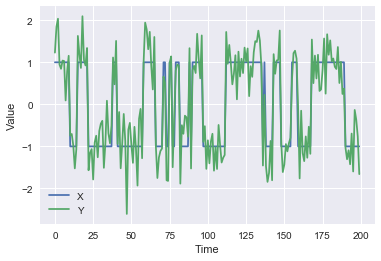

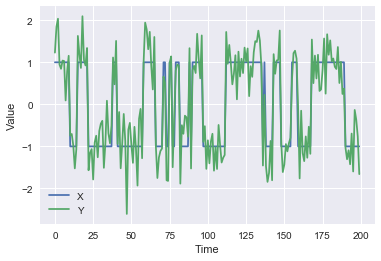

In [24]:
model = create_model(0.1,0.5)
T = 200
Y,X = model.sample(T)

def plot_hmm_traj(Y,X):
    meanY_fromX = list(map(lambda x: model.means_[x,0],X))
    fig, ax = plt.subplots(1)
    ax.plot(meanY_fromX)
    ax.plot(Y[:,0])
    ax.legend(["X","Y"])
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    plt.show(fig)
    return fig

plot_hmm_traj(Y,X)

---

### EXERCISE 3: Predict without evidence

In contrast with Sequential Probability Ratio Test, in HMM $p(x_t)$ is dependent of $p(x_{t-1})$, thus we could make predictions of future latent states even without further evidence. Let's make some predictions about $x_t$ given that we know for sure $x_0=1$. We've already imposed this assumption by setting prior probabilities of $p(x_0)$ to $[1,0]$ 

**Suggestions** 
- Complete the function to calculate the entropy for a Bernoulli distribution. *Hint*: add a small positive constant to prevent the singular value in `np.log`
- Generate a model with switching probability $0.1$
- Without observation the marginal distribution $p(x_{t+1})$ at time $t+1$ is simply calculated by multiplying $p(x_t)$ with the transition matrix: $p(x_{t+1})=A p(x_t)$. Calculate $p(x_t)$ for 20 time steps and collect prediction marginal probabilities for all time steps(including $t=0$).
- For each prediciton marginal $p(x_t)$, calculate the entropy $H_t$ and the information loss $H_t - H_0$. 
- Using pre-coded and commented codes, plot the entropy loss as a function of time .
- Play with different switching probabilities and observe how that affects the information loss.




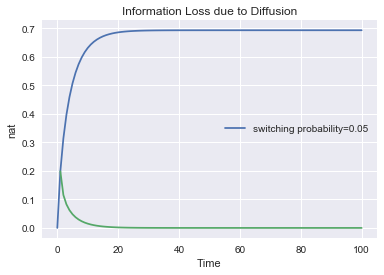

In [38]:

def entropy_binary(p):
    return -np.sum(list(map(lambda x: x*np.log(x+1e-10),p)))

switch_prob = 0.05
model = create_model(switch_prob,0.1)
T = 100
pt = np.asarray([1.0,0.0])
marginal_probs = [pt]
for t in range(T):
    pt = model.transmat_ @ pt
    marginal_probs.append(pt)
marginal_entropies = np.asarray(list(map(entropy_binary,marginal_probs)))
information_losses = marginal_entropies - marginal_entropies[0]
# information_losses_neighbor = marginal_entropies[1:] - marginal_entropies[:-1]

fig, ax = plt.subplots(1)
ax.plot(np.arange(T+1),information_losses)
ax.plot(np.arange(T) +1, information_losses_neighbor)
ax.legend(["switching probability={}".format(switch_prob)])
ax.set_xlabel("Time")
ax.set_ylabel("nat")
ax.set_title("Information Loss due to Diffusion")
plt.show(fig)

---

### EXERCISE 4:

Now let's incorporate evidence into our inference. In this exercise we will calculate the posterior marginal distribution $p(x_t|y_{1:t})$ recursively given evidence using the forward pass of the forward-backward algorithm.
That is saying, given we know the posterior marginal of $x_{t-1}$ given all observations up to $t-1$, when a new observation $y_t$ comes in, from Bayes' rule and the Markov property, we can get $p(x_{t}|y_{1:t})\propto p(x_t|y_{1:t-1})p(y_{t}|x_t)$, where the first term is the prediction from last exercise and the second term in the new data likelihood for two components:
$$\text{Posterior}(y_t|x_{1:t}) = \text{Prediction}(y_t|x_{1:t-1}) \odot \text{Likelihood}(y_t|x_t)$$

**Suggestions**

- Create a model with switching probability $0.1$ and noise level $0.5$
- Calcualte prediction(marginal) at time $t$ $p(x_t|y_{1:t-1})$ from last posterior $p(x_{t-1}|y_{1:t-1})$ at time $t-1$ 
- Calculate the likelihood of new data under each component using `exp(model._compute_log_likelihood(yt))`
- Multiply likelihood and prediction element-wise and normalize over two components to get the posterior probabilities
- Calculate the information gain by subtracting the posterior entropy from information loss from last exercise
- Plot the average information gain due to evidence together with information loss without evidence using codes are pre-written and commented.
- Adjust the switch probability and noise level and observe how information gain changes with signal-to-noise ratio and/or switch probability

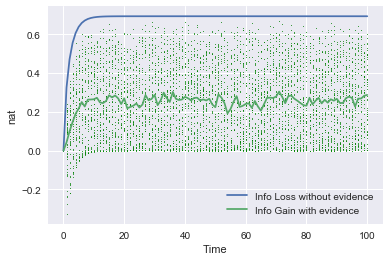

In [21]:
model = create_model(0.1, 2.0)
nsample = 50
info_gain_list = [] 
for i in range(nsample):
    # Re-calculate information loss using current model 
    pt = model.startprob_
    marginal_probs = [pt]
    for t in range(T):
        pt = model.transmat_ @ pt
        marginal_probs.append(pt)
    marginal_entropies = np.asarray(list(map(entropy_binary,marginal_probs)))
    information_losses = marginal_entropies - marginal_entropies[0]
    
    # Generate an observation trajectory condtioned on that latent state x is always 1
    Y = np.asarray([model._generate_sample_from_state(0) for _ in range(T+1)])
#     print(Y[1])
    # Calculate marginal for each latent state x_t 
    # First state
    pt = np.exp(model._compute_log_likelihood(Y[0:1])) * model.startprob_
    pt = normalize(pt,norm="l1")[0]
    posterior_list = [pt]
    for t in range(1,T+1):
        prediction = model.transmat_ @ pt
        likelihood = np.exp(model._compute_log_likelihood(Y[t:t+1]))
        posterior = prediction * likelihood
        posterior = normalize(posterior, norm="l1")[0]
        pt = posterior 
        posterior_list.append(pt)

    # Calculate entropy for each posterior marginal 
    posterior_vec = np.asarray(posterior_list) 
    posterior_entropies = np.asarray(list(map(entropy_binary,posterior_list)))
    info_gain = information_losses - posterior_entropies
    info_gain_list.append(info_gain)
info_gain_matrix = np.asarray(info_gain_list)
info_gain_mean = np.mean(info_gain_matrix,axis=0)


fig, ax = plt.subplots(1)
ax.plot(np.arange(T+1),information_losses)
ax.plot(np.arange(T+1), info_gain_mean)
ax.scatter(np.tile(np.arange(T+1),(nsample,1)),info_gain_matrix,s=0.4,c="green")
# ax.fill_between(np.arange(T+1),info_gain-info_loss_std, info_gain + info_loss_std, alpha=0.3)
ax.legend(["Info Loss without evidence","Info Gain with evidence"])
ax.set_xlabel("Time")
ax.set_ylabel("nat")
plt.show(fig)